<ipython-input-1-6dec11e5bece>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort_data['lifetime'] = (cohort_data['created_at'] - cohort_data['registration_date']).dt.days



Top features for 30 days prediction:
         feature  importance
0     amount_sum    0.351327
3   amount_count    0.174818
1    amount_mean    0.111891
2     amount_std    0.090551
11         dow_3    0.042997

Top features for 90 days prediction:
         feature  importance
0     amount_sum    0.342254
3   amount_count    0.156836
2     amount_std    0.077238
1    amount_mean    0.074330
14         dow_6    0.048667

Top features for 180 days prediction:
         feature  importance
0     amount_sum    0.298836
3   amount_count    0.156005
1    amount_mean    0.094346
11         dow_3    0.063056
9          dow_1    0.058393

Top features for 240 days prediction:
        feature  importance
0    amount_sum    0.287583
3  amount_count    0.151680
1   amount_mean    0.092267
9         dow_1    0.072369
8         dow_0    0.056256

Performance Metrics:

Lifetime 30 days:
MAE: 1.81
MSE: 469.04
RMSE: 21.66

Lifetime 90 days:
MAE: 10.97
MSE: 8151.18
RMSE: 90.28

Lifetime 180 days:
MAE: 1

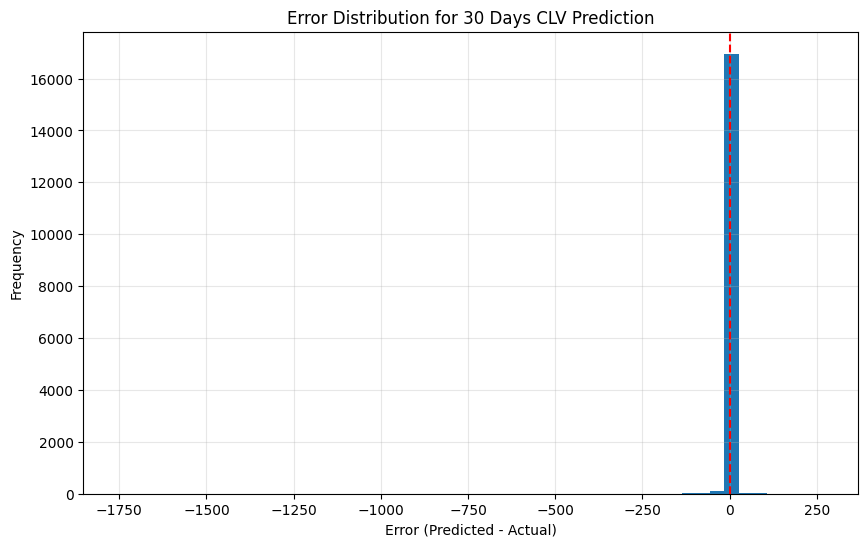

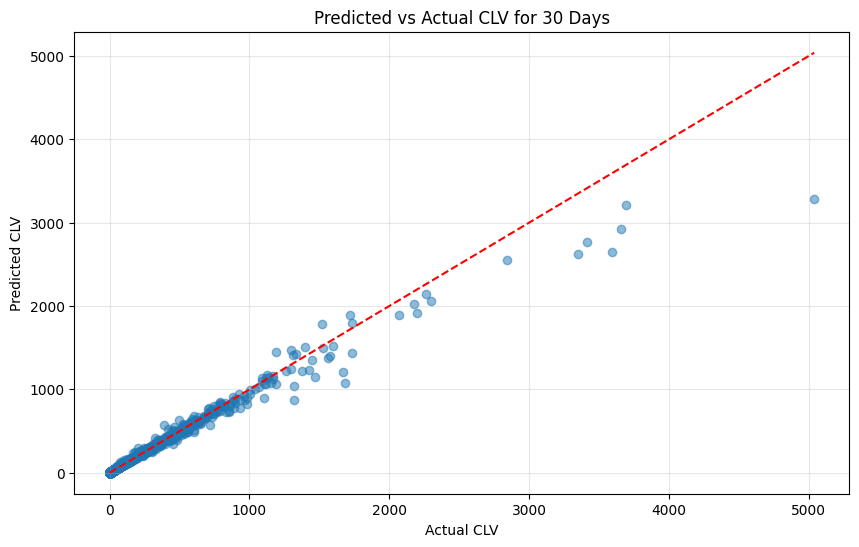

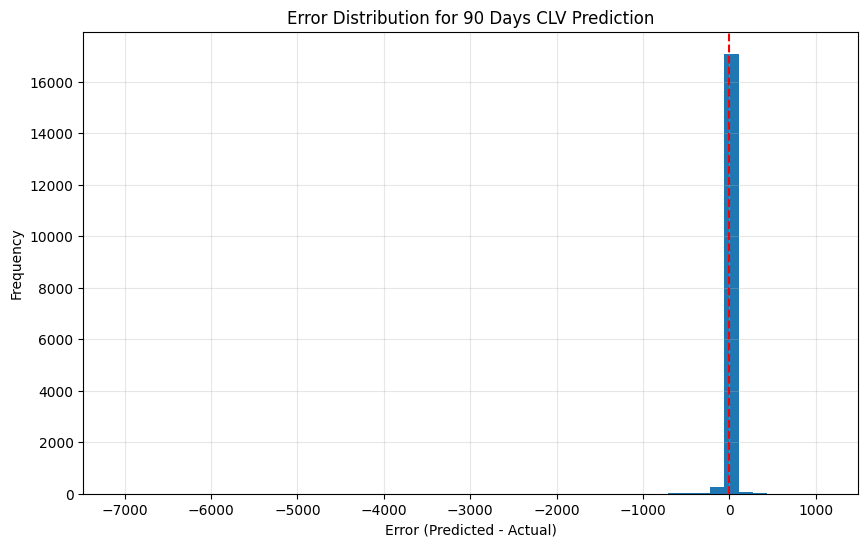

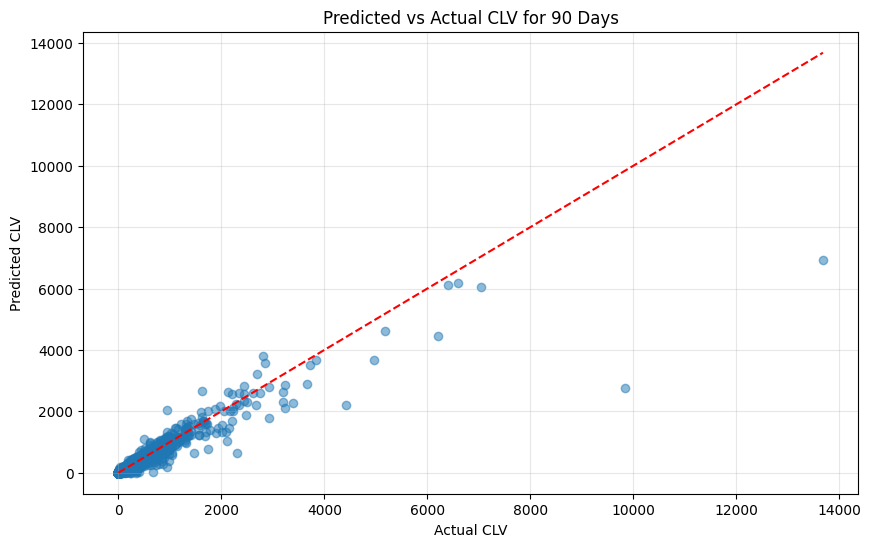

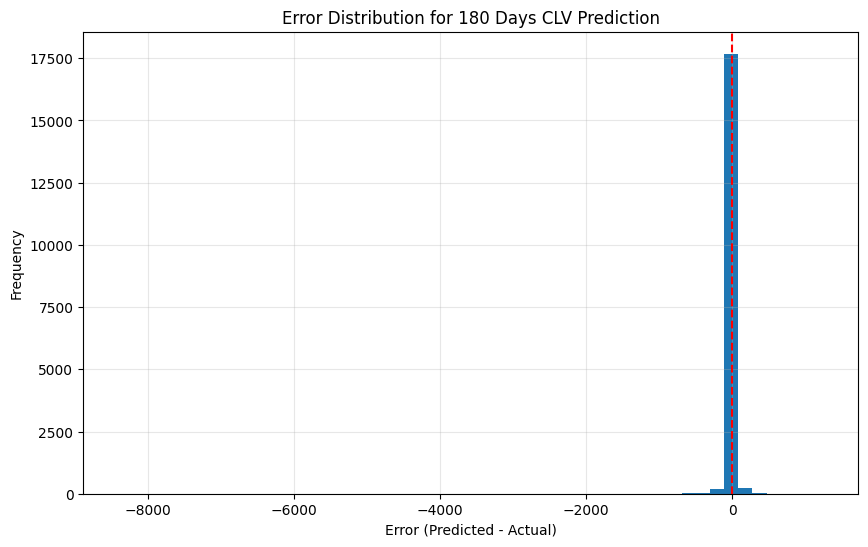

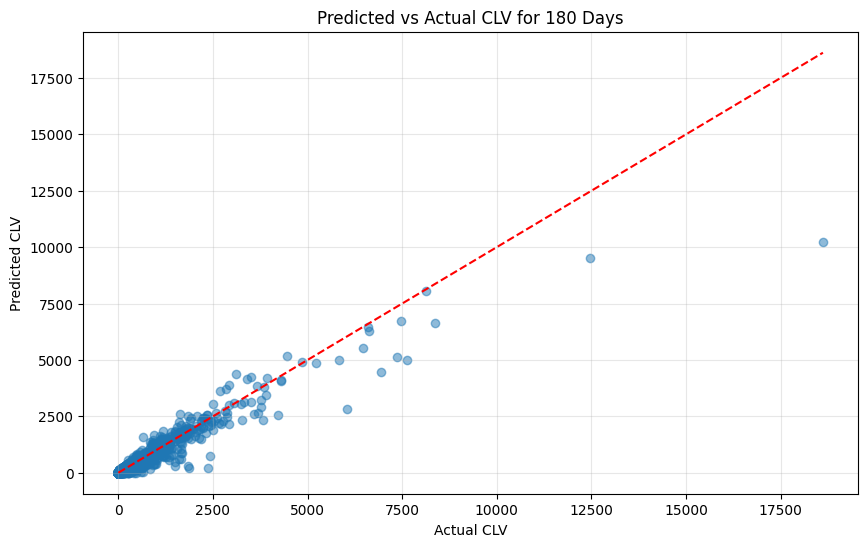

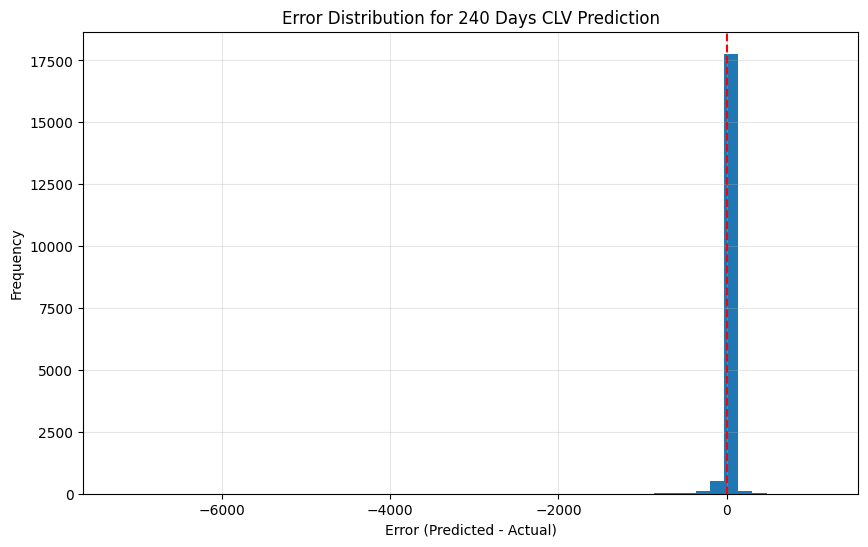

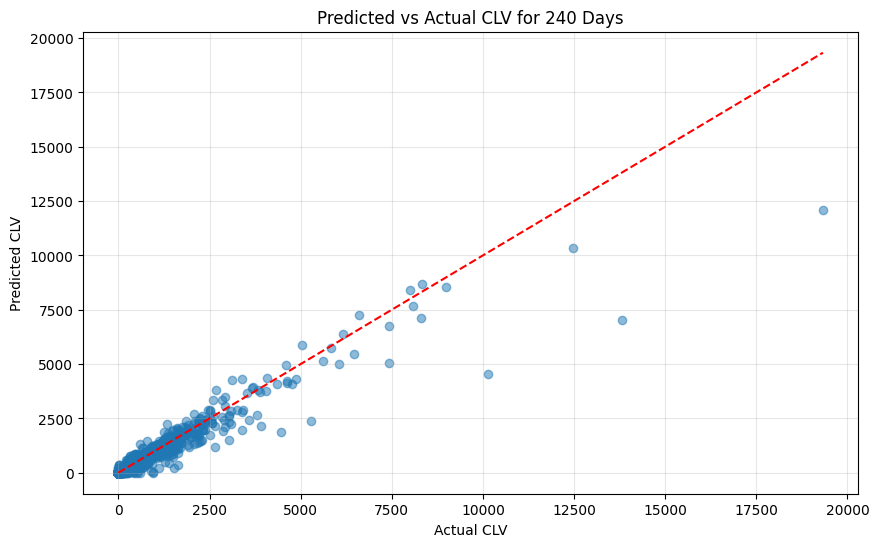


Execution time: 10.96 seconds


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time

# Start timing for performance measurement
start_time = time.time()

# Load data
data = pd.read_csv('transactions.csv')
data['created_at'] = pd.to_datetime(data['created_at'])
data['registration_date'] = pd.to_datetime(data['registration_date'])

# Filter June 2024 cohort
cohort_start = datetime(2024, 6, 1)
cohort_end = datetime(2024, 6, 30)
cohort_data = data[(data['registration_date'] >= cohort_start) &
                   (data['registration_date'] <= cohort_end)]

# Calculate lifetime in days for each transaction
cohort_data['lifetime'] = (cohort_data['created_at'] - cohort_data['registration_date']).dt.days

# Create features for ML approach
def prepare_features(df, max_days):
    # Filter data up to max_days
    filtered_df = df[df['lifetime'] <= max_days].copy()

    # Create user-level features
    user_features = filtered_df.groupby('user_id').agg({
        'amount': ['sum', 'mean', 'std', 'count'],
        'lifetime': ['max', 'mean']
    }).reset_index()

    # Flatten multi-level column names
    user_features.columns = ['_'.join(col).strip('_') for col in user_features.columns.values]

    # Add purchase frequency features
    user_features['purchase_freq'] = user_features['amount_count'] / (user_features['lifetime_max'] + 1)

    # Add time-based features (recency)
    user_features['recency'] = max_days - user_features['lifetime_max']

    # Add day of week distribution features
    dow_counts = filtered_df.groupby(['user_id',
                                       filtered_df['created_at'].dt.dayofweek]).size().unstack(fill_value=0)
    if not dow_counts.empty:
        dow_counts.columns = [f'dow_{i}' for i in dow_counts.columns]
        user_features = user_features.merge(dow_counts, on='user_id', how='left')
        user_features.fillna(0, inplace=True)

    return user_features

# Calculate actual CLV for different time periods
def calculate_actual_clv(df, lifetime_periods):
    actual_clv = {}

    for lt in lifetime_periods:
        user_totals = df[df['lifetime'] <= lt].groupby('user_id')['amount'].sum()
        actual_clv[lt] = user_totals.to_dict()

    return actual_clv

# Define time periods for prediction
lifetimes = [30, 90, 180, 240]

# Calculate actual CLV values for all users and periods
actual_clv_dict = calculate_actual_clv(cohort_data, lifetimes)

# Train models for each future period
models = {}
predictions = {}
metrics = {'mae': {}, 'mse': {}, 'rmse': {}}

# Get list of all users in the cohort
all_users = cohort_data['user_id'].unique()

# For each prediction period
for target_lt in lifetimes:
    # For training, we'll use a shorter period to predict the target period
    training_lt = max(30, target_lt // 2)  # Use half the target period or at least 30 days

    # Prepare features using the training period
    features_df = prepare_features(cohort_data, training_lt)

    # Get actual CLV for the target period
    target_values = pd.Series({user: actual_clv_dict[target_lt].get(user, 0) for user in features_df['user_id']})

    # Split data for training
    X = features_df.drop('user_id', axis=1)
    y = target_values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Random Forest model (faster and often more accurate than simulation)
    model = RandomForestRegressor(n_estimators=100, min_samples_leaf=2,
                                   max_features='sqrt', n_jobs=-1, random_state=42)
    model.fit(X_train, y_train)

    # Store model
    models[target_lt] = model

    # Make predictions for all users
    all_user_features = prepare_features(cohort_data, training_lt)
    X_all = all_user_features.drop('user_id', axis=1)
    user_ids = all_user_features['user_id']

    # Make predictions
    preds = model.predict(X_all)

    # Create DataFrame with predictions
    pred_df = pd.DataFrame({
        'user_id': user_ids,
        'predicted_clv': preds
    })

    # Store predictions
    predictions[target_lt] = pred_df

    # Calculate actual values for all users
    actual_values = []
    for user in user_ids:
        actual_values.append(actual_clv_dict[target_lt].get(user, 0))

    # Calculate metrics
    mae = mean_absolute_error(actual_values, preds)
    mse = mean_squared_error(actual_values, preds)
    rmse = np.sqrt(mse)

    metrics['mae'][target_lt] = mae
    metrics['mse'][target_lt] = mse
    metrics['rmse'][target_lt] = rmse

    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_all.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\nTop features for {target_lt} days prediction:")
    print(feature_importance.head(5))

# Print metrics
print("\nPerformance Metrics:")
for lt in lifetimes:
    print(f"\nLifetime {lt} days:")
    print(f"MAE: {metrics['mae'][lt]:.2f}")
    print(f"MSE: {metrics['mse'][lt]:.2f}")
    print(f"RMSE: {metrics['rmse'][lt]:.2f}")

# Visualization
for lt in lifetimes:
    plt.figure(figsize=(10, 6))

    # Get predictions and actual values
    preds = predictions[lt]['predicted_clv'].values
    actuals = []

    for user in predictions[lt]['user_id']:
        actuals.append(actual_clv_dict[lt].get(user, 0))

    # Calculate errors
    errors = preds - np.array(actuals)

    # Plot error distribution
    plt.hist(errors, bins=50)
    plt.title(f'Error Distribution for {lt} Days CLV Prediction')
    plt.xlabel('Error (Predicted - Actual)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.show()

    # Scatter plot of predicted vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals, preds, alpha=0.5)

    # Add perfect prediction line
    max_val = max(max(preds), max(actuals))
    plt.plot([0, max_val], [0, max_val], 'r--')

    plt.title(f'Predicted vs Actual CLV for {lt} Days')
    plt.xlabel('Actual CLV')
    plt.ylabel('Predicted CLV')
    plt.grid(True, alpha=0.3)
    plt.show()

# Print execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"\nExecution time: {execution_time:.2f} seconds")